**Task**

1. Implement content-based recommender system
     - Compute similarity between the user profile vector and each item vector
 
 
2. Implement hybrid recommender system
     - combine the results from the CF implementation from the tutorial and the content based recsys from this task
     - normalize the results from the CF and content based so that they are in the interval [0, 1]
     - aggregate the results using weighting scheme e.g. 0.3 for the content based, 0.7 for the collaborative filtering
 
**Rec-systems:**

1. CF : 
    - picks top K similar users from dataset based on cosine similarity (in my case - the used metric could be much improved)
    - from top users picks top N movies based on user rankings

2. CB
    - picks top N movies for user based on genre composition of his highest ranked movies

3. Hybrid
    - combines approaches by weighting normalized rankings from both CF and CB, from this new ranking picks top N movies
     
 
**Summary**

All results are shown in this notebook.
I have found that the result of hybrid recommendation are somewhat better
for CB rates around 0.1-0.3 (and 0.9-0.7 for collaborative filtering).
Hybrid ranking for this rate most times (but not always) improved over CF recommendations. CF always performed better than CB and is much more time consuming.
I evaluated recommendations for 5 randomly picked users, with 10 users for CF and 50 most recommended films. 



## Data preprocessign (part 1/4)

In [145]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
from math import sqrt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
import operator

movies = pd.read_csv('./movies.csv')
ratings = pd.read_csv('./ratings.csv')

In [146]:
movies_names = movies.copy()
movies_names = movies_names.set_index('movieId')
movies_names.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [147]:
vect = CountVectorizer(lowercase=False, tokenizer=lambda s: s.split('|'), binary=True)
movies = pd.DataFrame((vect.fit_transform(movies['genres'])).toarray(), index = movies['movieId'], columns = vect.get_feature_names())
genres = vect.get_feature_names()
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [148]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [149]:
## merge ratings with movies and keep only movies rated above 2.5
users = pd.merge(ratings, movies,right_on='movieId', left_index=True)#how='outer')
users = users[users.rating >= 2.5]
users.drop(columns=['rating','timestamp','movieId'], inplace=True)
users = users.groupby('userId').sum()
display(users.head())

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,0,32,26,3,18,69,29,8,98,9,1,10,1,3,14,43,11,37,8,2
2,0,3,3,1,6,13,2,1,10,2,0,1,0,1,0,7,2,2,0,0
3,0,1,0,0,0,8,3,0,11,0,0,1,0,0,0,5,1,4,1,1
4,0,25,13,2,9,62,15,0,76,7,1,6,1,2,5,30,5,30,4,5
5,0,12,5,2,3,9,5,1,16,4,0,1,0,2,3,4,3,8,1,1


### Re-used functions from tutorials

In [150]:
def cosine_sim(person1, person2,df):
    # computes similarity between two users based on the cosine similarity metric
    if(person1 not in df.index):
        return -1
    if(person2 not in df.index):
        return -1
    
    A = np.array(df.loc[person1,:])
    B = np.array(df.loc[person2,:])
    a_new = []
    b_new = []
    for i in range(len(A)):
        if(A[i] > 0 and B[i] > 0):
            a_new.append(A[i])
            b_new.append(B[i])
    A = np.array(a_new)
    B = np.array(b_new)
    
    if(len(A) < 1):
        return 0
    sim = np.sum((A*B))/(np.linalg.norm(A)*np.linalg.norm(B))
    return sim

In [151]:
def most_similar_users(person, df, k):
    # returns top-K similar users for given user
    indexes = list(df[df.index != person].index)
    cos_sim = []
    for user in indexes:
        if(user == person):
            continue
        if(df.index.contains(user)):
            cos_sim.append(cosine_sim(person, user,df))
    
    users = pd.DataFrame()
    users['idx'] = indexes
    users['cosine'] = cos_sim
    users = users.sort_values('cosine', ascending=False)
    cos_indxes = np.array(users.idx[:k])
    #print("Most similar users by Cosine sim.:")
    #display(df.iloc[cos_indxes,:])
    return cos_indxes

In [152]:
def movie_recommendations(person, m_u, k_users, k_items):
    # generate recommendations for the given user
    similar = most_similar_users(person, m_u, k_users)
    unrated = []
    user = m_u.loc[person,:]
    for i,val in enumerate(user):
        if val ==0:
            unrated.append(i+1)

    if(len(unrated) < 1):
        print("User has no unrated items.")
        return
    
    recommended = {}
    items = m_u.columns
    seen = ratings[ratings.userId == person].movieId
    for user in similar:
        for item_index in items:
            if(item_index not in recommended):
                recommended[item_index] = 0
            elif(item_index in seen):
                recommended[item_index] = 0
            else:
                if(m_u.loc[user, item_index] > 0):
                    recommended[item_index] += m_u.loc[user, item_index]

    sorted_rec = sorted(recommended.items(), key=operator.itemgetter(1), reverse=True)
    if( k_items > -1):
        k_rec = [ k for k in sorted_rec][:k_items]
    else:
        k_rec = [ k for k in sorted_rec]
        
    return k_rec

In [153]:
def print_movies(movie_ids):
    for mid in movie_ids:
        if(len(movies_names.loc[mid]) > 0):
            print('\t', movies_names.loc[mid,'title'])
        else:
            print('\t','<?> title missing <?>','id',mid)
    
    
def print_users(users_ids):
    for uid in users_ids:
        if(len(users.loc[uid]) > 0):
            print(users.loc[uid,'name'],'id',uid)
        else:
            print('<?> name missing <?>','id',uid)

### Compute similarity between the user profile vector and each item vector

In [10]:
user_movie = pd.DataFrame(cosine_similarity(movies, users), columns=users.index, index=movies.index)
user_movie.head()

userId,1,2,3,4,5,6,7,8,9,10,...,600,601,602,603,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.384861,0.564692,0.230940,0.368972,0.398571,0.542396,0.484814,0.437816,0.314373,0.364718,...,0.795990,0.461880,0.471940,0.306186,0.471940,0.445669,0.430706,0.445669,0.000000,0.306412
2,0.210666,0.320767,0.000000,0.148536,0.268462,0.295872,0.308882,0.308301,0.156098,0.198252,...,0.529379,0.149071,0.348155,0.131762,0.087039,0.239732,0.000000,0.191785,0.000000,0.083279
3,0.545233,0.714286,0.593366,0.577123,0.356198,0.543551,0.667005,0.377590,0.497067,0.475500,...,0.324177,0.730297,0.000000,0.484123,0.426401,0.381693,0.595880,0.587220,0.500000,0.484480
4,0.834715,0.874818,0.894427,0.860487,0.648784,0.788991,0.861618,0.693677,0.811708,0.809530,...,0.389249,0.745356,0.087039,0.764217,0.522233,0.647275,0.625543,0.815088,0.816497,0.687053
5,0.475038,0.656599,0.516398,0.550031,0.348743,0.580794,0.492762,0.266996,0.432590,0.429229,...,0.350584,0.774597,0.000000,0.410792,0.603023,0.456750,0.601929,0.581318,0.000000,0.432731


In [154]:
#remove already seen movies -> we dont want to recommend those
for user in user_movie.columns:
    seen = ratings[ratings.userId == user].movieId.tolist()
    user_movie.loc[seen, user] = 0

user_movie.head()

userId,1,2,3,4,5,6,7,8,9,10,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.478091,0.286039,0.371220,0.000000,0.315925,0.000000,0.255583,0.490399,0.608751,...,0.000000,0.000000,0.353553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.237971,0.231455,0.000000,0.152950,0.208333,0.000000,0.165474,0.000000,0.361773,0.341693,...,0.000000,0.000000,0.000000,0.248452,0.000000,0.000000,0.073472,0.242536,0.000000,0.038069
3,0.000000,0.850420,0.452267,0.599438,0.510310,0.000000,0.552720,0.359211,0.387694,0.544033,...,0.452267,0.262613,0.670820,0.365148,0.500000,0.353553,0.404929,0.594089,0.000000,0.326377
4,0.822082,0.925820,0.738549,0.866715,0.875000,0.000000,0.797286,0.769897,0.587880,0.785894,...,0.000000,0.536056,0.912871,0.695666,0.816497,0.673575,0.697982,0.808452,0.631933,0.761387
5,0.449649,0.668153,0.639602,0.565156,0.433013,0.000000,0.547165,0.381000,0.313304,0.591830,...,0.000000,0.371391,0.474342,0.430331,0.000000,0.333333,0.381771,0.560112,0.298511,0.263752


## Recommender functions (part 2/4)

In [37]:
# CB - returning top N movies per person
def CBrec_topN(df, person, N):
    rating_mat = df.copy()
    
    user_col = rating_mat.loc[:,person]
    rating_mat = user_col.sort_values(ascending=False)
    top_movies = rating_mat.index.tolist()
    if(N > 0):
        top_movies = top_movies[:N]
    else:
        top_movies = rating_mat.to_frame(name='rank')
        
    return top_movies
    

In [130]:
#HYBRID rank
def HYBRIDrec_topN(person, N, m_u, df, weight, tableOut = True):
    cb_w = weight
    cf_w = 1.0 - weight
    
    rec = movie_recommendations(person, m_u, 10, -1)
    #normalization
    cf_movies = [x[0] for x in rec]
    cf_ranks = [x[1] for x in rec]
    normalizer = preprocessing.MinMaxScaler()
    cf_df = pd.DataFrame(cf_ranks, columns=['rank'],index = cf_movies)
    cf_df = pd.DataFrame(normalizer.fit_transform(cf_df), columns=['rank'], index=cf_movies)
    cf_df['movieId'] = cf_df.index
    #already normalized
    cb_rec = CBrec_topN(df, person, -1)
    cb_df = cb_rec.copy()
    cb_df['movieId'] = cb_df.index
    
    
    movies_rec = cf_df.join(cb_df, on='movieId',how='outer', lsuffix='_cf', rsuffix='_cb')
    movies_rec['hybrid_rank'] = cf_w*movies_rec['rank_cf'] + cb_w*movies_rec['rank_cb']
    movies_rec.sort_values(by='hybrid_rank', ascending=False, inplace=True)
    movies_rec.drop(columns=['movieId','movieId_cf', 'movieId_cb'], inplace=True)
    movies_rec['title'] = movies_names.loc[movies_rec.index, 'title']
    if(tableOut):
        display(movies_rec.head(10))
    return movies_rec.index.tolist()[:N]
    


## Testing (part 3/4)
### User selection

In [155]:
import random
#testing pool with user that has not seen many movies
#display(ratings.userId.value_counts())
short = [399,53,431,442,147,406,189,194,278]
selection = random.sample(short,2)
selection = [53,147,278]

### Collaborative Filtering

‒ analyze the user-item interactions for each user, and
recommend items from similar users


In [16]:
m_u = pd.read_csv('./ratings.csv').pivot('userId','movieId','rating')
m_u.fillna(0,inplace=True)
display(m_u.head())

N = 3
print("Collaborative Filtering")
for user in selection[:1]:
    seen = ratings[ratings.userId == user].movieId
    print('User ',user,'has seen:')
    print_movies(seen)
    print('CF Recommended for user',user,':')
    rec = movie_recommendations(user, m_u, 10, N)
    rec = [x[0] for x in rec]
    print_movies(rec)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Collaborative Filtering
User  53 has seen:
	 To Wong Foo, Thanks for Everything! Julie Newmar (1995)
	 Immortal Beloved (1994)
	 When a Man Loves a Woman (1994)
	 Airheads (1994)
	 Kalifornia (1993)
	 Arrival, The (1996)
	 Island of Dr. Moreau, The (1996)
	 Roman Holiday (1953)
	 Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
	 Ghost and the Darkness, The (1996)
	 Days of Thunder (1990)
	 Return of the Pink Panther, The (1975)
	 Duck Soup (1933)
	 Pink Floyd: The Wall (1982)
	 Benny & Joon (1993)
	 Halloween (1978)
	 Dick Tracy (1990)
	 Red Violin, The (Violon rouge, Le) (1998)
	 River Runs Through It, A (1992)
	 Finding Forrester (2000)
CF Recommended for user 53 :
	 Forrest Gump (1994)
	 Matrix, The (1999)
	 Blade Runner (1982)


### Content-based recommender system
‒ analyze the content of the items (bought books) and
recommend similar content (similar books)

In [17]:
N = 10
print("Content-Based Filtering")
for user in selection:
    seen = ratings[ratings.userId == user].movieId
    print('User ',user,'has seen:')
    #print_movies(seen)
    print('CBF Recommended for user:')
    rec = CBrec_topN(user_movie, user, N)
    print_movies(rec)

Content-Based Filtering
User  53 has seen:
CBF Recommended for user:
	 Monsieur Ibrahim (Monsieur Ibrahim et les fleurs du Coran) (2003)
	 Eighth Day, The (Huitième jour, Le) (1996)
	 Manon of the Spring (Manon des sources) (1986)
	 North Country (2005)
	 Two for the Money (2005)
	 On Golden Pond (1981)
	 Glory Daze (1995)
	 Goal! The Dream Begins (Goal!) (2005)
	 Drunks (1995)
	 Howards End (1992)
User  147 has seen:
CBF Recommended for user:
	 Killing Zoe (1994)
	 I Know Who Killed Me (2007)
	 Street Kings (2008)
	 Roaring Twenties, The (1939)
	 All About Lily Chou-Chou (Riri Shushu no subete) (2001)
	 Bully (2001)
	 Samouraï, Le (Godson, The) (1967)
	 Sentinel, The (2006)
	 Blood and Wine (Blood & Wine) (1996)
	 Limey, The (1999)
User  278 has seen:
CBF Recommended for user:
	 Ichi the Killer (Koroshiya 1) (2001)
	 Another 48 Hrs. (1990)
	 Last Boy Scout, The (1991)
	 Wasabi (2001)
	 Bad Boys (1995)
	 Metro (1997)
	 Money Train (1995)
	 Pusher III: I'm the Angel of Death (2005)
	 Os

### Hybrid recommender system

In [156]:
## normalizing values between 1,0

normalizer = preprocessing.MinMaxScaler()
norm_user_movie = pd.DataFrame(normalizer.fit_transform(user_movie), columns=user_movie.columns, index=user_movie.index)
norm_user_movie.head()

userId,1,2,3,4,5,6,7,8,9,10,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.516398,0.316228,0.428306,0.000000,0.363668,0.000000,0.299584,0.589855,0.727172,...,0.000000,0.000000,0.387298,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.277792,0.250000,0.000000,0.176471,0.238095,0.000000,0.185195,0.000000,0.435143,0.408163,...,0.000000,0.000000,0.000000,0.293408,0.000000,0.000000,0.083333,0.276642,0.000000,0.044412
3,0.000000,0.918559,0.500000,0.691621,0.583212,0.000000,0.618590,0.421053,0.466321,0.649865,...,0.499134,0.287480,0.734847,0.431220,0.500000,0.385695,0.459279,0.677631,0.000000,0.380750
4,0.959645,1.000000,0.816497,1.000000,1.000000,0.000000,0.892301,0.902444,0.707107,0.938776,...,0.000000,0.586816,1.000000,0.821542,0.816497,0.734809,0.791667,0.922139,0.740779,0.888231
5,0.524891,0.721688,0.707107,0.652066,0.494872,0.000000,0.612372,0.446594,0.376845,0.706960,...,0.000000,0.406558,0.519615,0.508197,0.000000,0.363636,0.433013,0.638877,0.349927,0.307692


In [157]:
N = 5
print("HYBRID")
rate = 0.3
for user in selection[:1]:
    seen = ratings[ratings.userId == user].movieId
    print('User ',user,'has seen:')
    print_movies(seen)
    print('Recommended for user',user,'and rate',rate,':')
    rec = HYBRIDrec_topN(user, N, m_u, norm_user_movie, rate)
    #print_movies(rec)

HYBRID
User  53 has seen:
	 To Wong Foo, Thanks for Everything! Julie Newmar (1995)
	 Immortal Beloved (1994)
	 When a Man Loves a Woman (1994)
	 Airheads (1994)
	 Kalifornia (1993)
	 Arrival, The (1996)
	 Island of Dr. Moreau, The (1996)
	 Roman Holiday (1953)
	 Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
	 Ghost and the Darkness, The (1996)
	 Days of Thunder (1990)
	 Return of the Pink Panther, The (1975)
	 Duck Soup (1933)
	 Pink Floyd: The Wall (1982)
	 Benny & Joon (1993)
	 Halloween (1978)
	 Dick Tracy (1990)
	 Red Violin, The (Violon rouge, Le) (1998)
	 River Runs Through It, A (1992)
	 Finding Forrester (2000)
Recommended for user 53 and rate 0.3 :


,rank_cf,rank_cb,hybrid_rank,title
1265,1.000000,0.329914,0.798974,Groundhog Day (1993)
500,0.666667,0.808122,0.709103,Mrs. Doubtfire (1993)
318,0.822222,0.404061,0.696774,"Shawshank Redemption, The (1994)"
2918,0.733333,0.571429,0.684762,Ferris Bueller's Day Off (1986)
1222,0.800000,0.404061,0.681218,Full Metal Jacket (1987)
3578,0.600000,0.824786,0.667436,Gladiator (2000)
1777,0.777778,0.404061,0.665663,"Wedding Singer, The (1998)"
2716,0.577778,0.824786,0.651880,Ghostbusters (a.k.a. Ghost Busters) (1984)
2011,0.644444,0.659829,0.649060,Back to the Future Part II (1989)
4370,0.644444,0.659829,0.649060,A.I. Artificial Intelligence (2001)


## Evaluation (part 4/4)

In [20]:
from sklearn.model_selection import train_test_split

"""
Returns precision for given query retrieval: - ratio of relevant documents to retrieved
"""
def getPrecision(true_pos, false_pos):
    return (float(true_pos)) / float(true_pos + false_pos)

"""
Returns recallfor given query retrieval: - ratio of retrieved documents to relevant {what should have been found}
"""
def getRecall(true_pos, false_neg):
    return (float(true_pos)) / float(true_pos + false_neg)

"""
Returns F-score
"""
def getFMeasure(precision, recall):
    if(precision == 0.0 or recall == 0.0):
        return 0.0
    else:
        return 2. * ( float(precision*recall) / float(precision + recall) )

In [134]:
"""
Filling all matrices again with training data only for evaluation purposes
"""
test_ratings = pd.read_csv('./test-ratings.csv', header=None, names=['userId','movieId', 'ratings','timestamp'])
#display(test_ratings.head())
m_u = pd.read_csv('./new-ratings.csv').pivot('userId','movieId','rating')
m_u.fillna(0,inplace=True)
#display(m_u.head())

## merge ratings with movies and keep only movies rated above 2.5
ratings = pd.read_csv('./new-ratings.csv')
users = pd.merge(ratings, movies,right_on='movieId', left_index=True)#how='outer')
users = users[users.rating >= 2.5]
users.drop(columns=['rating','timestamp','movieId'], inplace=True)
users = users.groupby('userId').sum()


user_movie = pd.DataFrame(cosine_similarity(movies, users), columns=users.index, index=movies.index)
for user in user_movie.columns:
    seen = ratings[ratings.userId == user].movieId.tolist()
    user_movie.loc[seen, user] = 0

normalizer = preprocessing.MinMaxScaler()
norm_user_movie = pd.DataFrame(normalizer.fit_transform(user_movie), columns=user_movie.columns, index=user_movie.index)

In [22]:
"""
Returns scores for seen movies and recommended movies sets
"""
def getFeedback(test_seen, rec, printOut=True):
    false_pos = 0
    false_neg = 0
    true_pos = 0
    true_neg = 0
    tp_fn = 0
    tp_fp = 0
    
    for mov in rec:
        if(mov in test_seen):
            tp_fn += 1 
            true_pos += 1
        if(mov in rec):
            tp_fp += 1
            
    false_neg = tp_fn - true_pos
    false_pos = tp_fp - true_pos
            
    false_neg = len(list(set(test_seen) - set(rec)))
    precision = getPrecision(true_pos, false_pos)
    recall = getRecall(true_pos, false_neg)
    f_measure = getFMeasure(precision, recall)
    if(printOut):
        print('true positive:',true_pos)
        print('false positive:',false_pos)
        print('false negative:',false_neg)
        print('precision:',precision)
        print('recall:',recall)
        print('f-measure:',f_measure)
    return precision, recall, f_measure
    

In [87]:
print("Collaborative Filtering - testing instance")
N=50
for user in selection[2:3]:
    user_seen = test_ratings[test_ratings.userId == user]
    user_seen = user_seen.sort_values(by='ratings',ascending=False)
    test_seen = user_seen.movieId.tolist()
    print('CF Recommended for user',user,' (first 10):')
    rec = movie_recommendations(user, m_u, 10, N)
    rec = [x[0] for x in rec]
    print_movies(rec[:10])
    print("Really seen:")
    print_movies(test_seen)
    getFeedback(test_seen,rec)

Collaborative Filtering - testing instance
CF Recommended for user 56  (first 10):
	 Shawshank Redemption, The (1994)
	 Good Will Hunting (1997)
	 Dead Poets Society (1989)
	 Silence of the Lambs, The (1991)
	 Beautiful Mind, A (2001)
	 Dark Knight, The (2008)
	 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
	 Wolf of Wall Street, The (2013)
	 Matrix, The (1999)
	 Kill Bill: Vol. 2 (2004)
Really seen:
	 Silence of the Lambs, The (1991)
	 Jurassic Park (1993)
	 Forrest Gump (1994)
	 Ace Ventura: Pet Detective (1994)
	 American President, The (1995)
	 Specialist, The (1994)
	 Terminator 2: Judgment Day (1991)
	 True Lies (1994)
	 Clueless (1995)
	 Santa Clause, The (1994)
	 Outbreak (1995)
	 Disclosure (1994)
	 Crimson Tide (1995)
	 Batman Forever (1995)
	 Friday (1995)
	 Eraser (1996)
	 Interview with the Vampire: The Vampire Chronicles (1994)
	 Star Trek: Generations (1994)
	 Species (1995)
	 Mask, The (1994)
	 Judge Dredd (1995)
	 Beverly Hills Cop III 

In [103]:
selection = random.sample(users.index.tolist(), 10) #random 4 users

In [135]:

print("Content based")
N=50
prec = []
recall = []
fm = []

for user in selection:
    user_seen = test_ratings[test_ratings.userId == user]
    user_seen = user_seen.sort_values(by='ratings',ascending=False)
    test_seen = user_seen.movieId.tolist()[:N]
    
    rec = CBrec_topN(user_movie, user, N)
    p,r,f = getFeedback(test_seen,rec, False)
    prec.append(p)
    recall.append(r)
    fm.append(f)
    
print('Average feedback:')
print('Precision:', sum(prec)/len(prec))
print('Recall:', sum(recall)/len(recall))
print('F-measure:', sum(fm)/len(fm))

Content based
Average feedback:
Precision: 0.016
Recall: 0.02146843853820598
F-measure: 0.017275537634408603


In [136]:
print("Collaborative Filtering")
N=50

prec = []
recall = []
fm = []

for user in selection:
    user_seen = test_ratings[test_ratings.userId == user]
    user_seen = user_seen.sort_values(by='ratings',ascending=False)
    test_seen = user_seen.movieId.tolist()[:N]
    rec = movie_recommendations(user, m_u, 10, N)
    rec = [x[0] for x in rec]
    p,r,f = getFeedback(test_seen,rec, False)
    prec.append(p)
    recall.append(r)
    fm.append(f)
    
print('Average feedback:')
print('Precision:', sum(prec)/len(prec))
print('Recall:', sum(recall)/len(recall))
print('F-measure:', sum(fm)/len(fm))    

Collaborative Filtering
Average feedback:
Precision: 0.05600000000000001
Recall: 0.07745293466223699
F-measure: 0.06243405437479771


In [137]:
print("Hybrid")
N=50
rates = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.7]
F_ms = []

for rate in rates:
    prec = []
    recall = []
    fm = []

    for user in selection:
        user_seen = test_ratings[test_ratings.userId == user]
        user_seen = user_seen.sort_values(by='ratings',ascending=False)
        test_seen = user_seen.movieId.tolist()[:N]
        
        rec = HYBRIDrec_topN(user, N, m_u, norm_user_movie, rate, False)
        p,r,f = getFeedback(test_seen,rec, False)
        prec.append(p)
        recall.append(r)
        fm.append(f)
    print('\nRate:',rate)
    print('Average feedback:')
    print('Precision:', sum(prec)/len(prec))
    print('Recall:', sum(recall)/len(recall))
    print('F-measure:', sum(fm)/len(fm))
    F_ms.append(sum(fm)/len(fm))

Hybrid

Rate: 0.1
Average feedback:
Precision: 0.052000000000000005
Recall: 0.07031007751937983
F-measure: 0.057305849246592586

Rate: 0.15
Average feedback:
Precision: 0.05400000000000001
Recall: 0.07231007751937983
F-measure: 0.05930584924659259

Rate: 0.2
Average feedback:
Precision: 0.056000000000000015
Recall: 0.07431007751937983
F-measure: 0.06130584924659258

Rate: 0.25
Average feedback:
Precision: 0.05800000000000002
Recall: 0.07631007751937983
F-measure: 0.06330584924659258

Rate: 0.3
Average feedback:
Precision: 0.05800000000000001
Recall: 0.07663565891472868
F-measure: 0.06345638688100118

Rate: 0.35
Average feedback:
Precision: 0.054000000000000006
Recall: 0.060778516057585844
F-measure: 0.056642284316898626

Rate: 0.4
Average feedback:
Precision: 0.054000000000000006
Recall: 0.060452934662237
F-measure: 0.05649174668249002

Rate: 0.5
Average feedback:
Precision: 0.044
Recall: 0.05212735326688815
F-measure: 0.04633800391987629

Rate: 0.7
Average feedback:
Precision: 0.01799

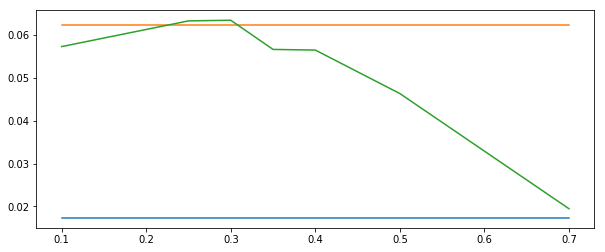

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sns.lineplot(x=rates,y=0.0173) #CB
sns.lineplot(x=rates,y=0.0624) #CF
sns.lineplot(x=rates,y=F_ms) #Hybrid
plt.show()